In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt

## Update to use the annealed optimizer

In [19]:
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
dt = 0.2
noise_var = 4.
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)


trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 50. * n_colloc * 3
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.25,alpha = 0.1)
    )

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )


optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier,
        num_annealing_steps = 2,
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    expdata.t_train,
    expdata.x_train,
    t_colloc = expdata.t_colloc,
    w_colloc = expdata.w_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.e-05, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 75750.0}
Solving for data_weight = 1.0, colloc_weight = 15150.0 beta_reg = 0.002


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 4.713e+06, gradnorm = 1.507e+07, alpha = 4.167, improvement_ratio = 0.8049
Iteration 1, loss = 9.54e+05, gradnorm = 6.655e+07, alpha = 4.167, improvement_ratio = 0.7977
Iteration 2, loss = 6.245e+05, gradnorm = 3.067e+07, alpha = 1.825e+03, improvement_ratio = 0.3467
Iteration 3, loss = 1.964e+05, gradnorm = 7.282e+07, alpha = 100.0, improvement_ratio = 0.6861
Iteration 4, loss = 2.059e+04, gradnorm = 2.841e+07, alpha = 83.33, improvement_ratio = 0.8978
Iteration 5, loss = 8.664e+03, gradnorm = 1.847e+07, alpha = 125.0, improvement_ratio = 0.5943
Iteration 100, loss = 226.9, gradnorm = 3.806e+04, alpha = 1.509, improvement_ratio = 0.7706
Line Search Failed!
Final Iteration Results
Iteration 191, loss = 191.9, gradnorm = 0.005233, alpha = 178.1, improvement_ratio = -1.229e+05
Solving for data_weight = 1.0, colloc_weight = 75750.0 beta_reg = 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 198.5, gradnorm = 648.3, alpha = 102.5, improvement_ratio = 0.1698
Iteration 1, loss = 197.4, gradnorm = 9.041e+04, alpha = 83.33, improvement_ratio = 0.9128
Iteration 2, loss = 197.0, gradnorm = 3.351e+04, alpha = 69.44, improvement_ratio = 0.8543
Iteration 3, loss = 196.6, gradnorm = 2.483e+04, alpha = 57.87, improvement_ratio = 0.8811
Iteration 4, loss = 196.3, gradnorm = 1.742e+04, alpha = 48.23, improvement_ratio = 0.8951
Iteration 5, loss = 196.1, gradnorm = 1.352e+04, alpha = 40.19, improvement_ratio = 0.8979
Line Search Failed!
Final Iteration Results
Iteration 91, loss = 193.9, gradnorm = 0.08398, alpha = 480.8, improvement_ratio = -9.489e+04
Model after smooth warm start
(x)' = 28.585 1 + 1.396 x + 2.904 y + -3.651 z + -1.375 x^2 + 2.128 x y + -0.432 x z + -0.783 y^2 + 0.299 y z + 0.112 z^2
(y)' = -29.971 1 + 24.535 x + 3.541 y + 4.903 z + 2.437 x^2 + -2.661 x y + -0.825 x z + 0.690 y^2 + -0.249 y z + -0.188 z^2
(z)' = 1.485 1 + -3.151 x + 0.589 y + -2.075

In [20]:
model.opt_result[-1].history['objval'][-1]

[Array(226.79166964, dtype=float64)]

In [21]:
model.print()

(x)' = -9.371 x + 9.734 y
(y)' = 27.977 x + -1.163 y + -0.980 x z
(z)' = -2.662 z + 1.045 x y


In [7]:
model.print(expdata.true_coeff.T)

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


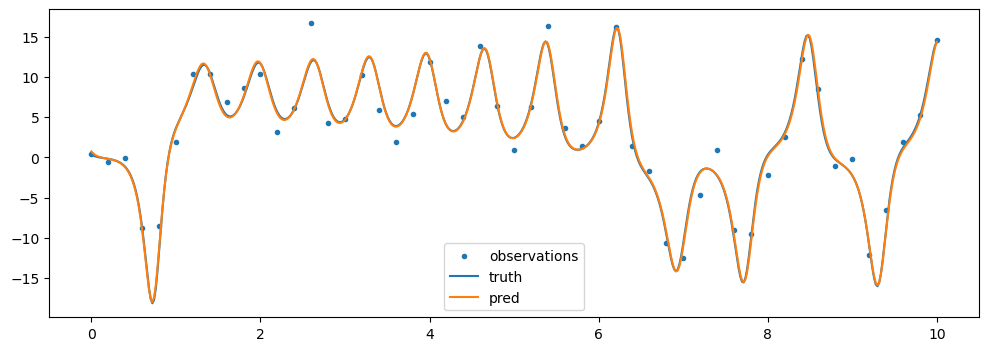

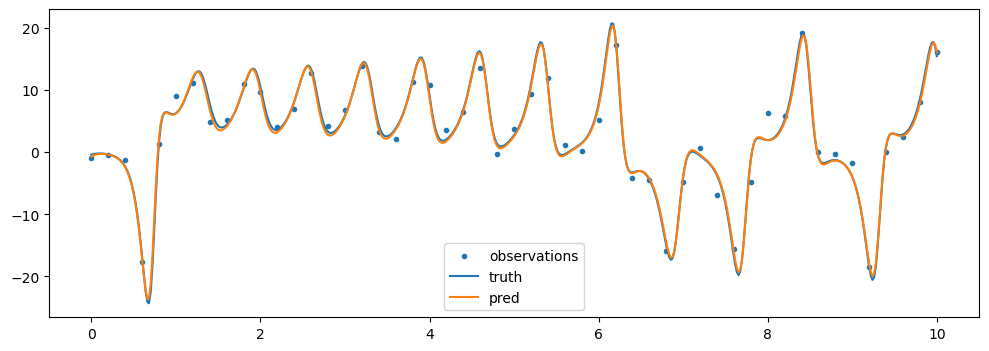

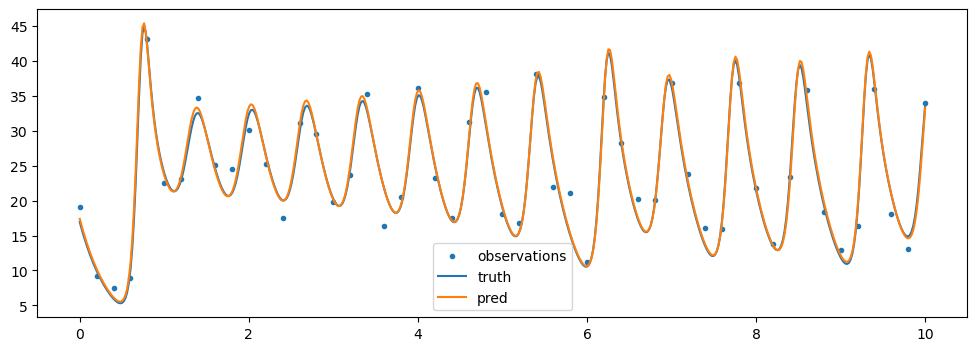

In [8]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth')
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()


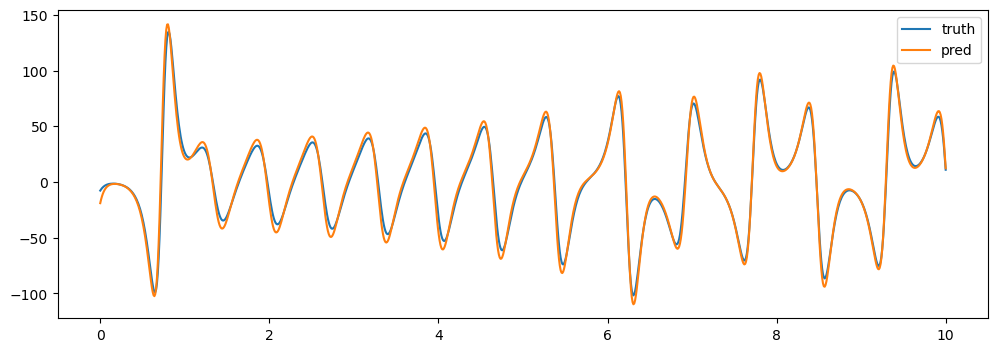

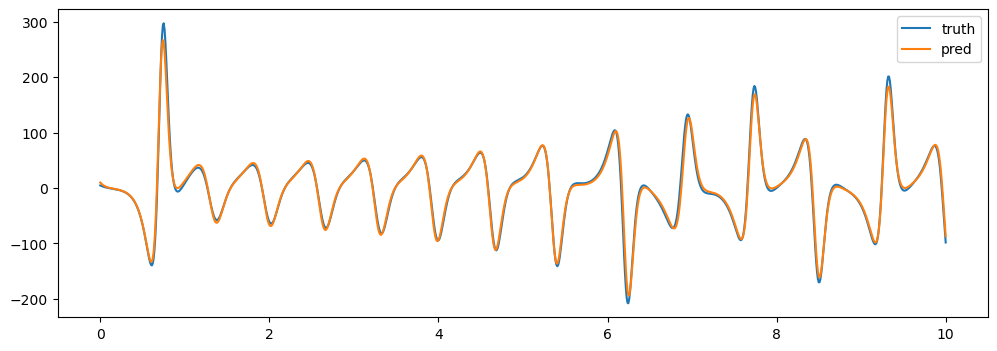

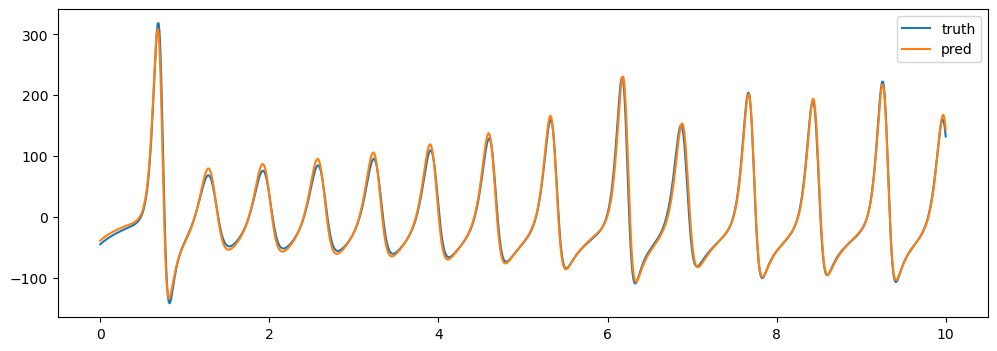

In [59]:
t_grid = jnp.linspace(0,10,1000)
dx_preds = model.traj_model.derivative(t_grid,model.z,1)

true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
true_dx = model.predict(true_states,expdata.true_coeff.T)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.plot(t_grid,true_dx[:,dim],label = 'truth')
    plt.plot(t_grid,dx_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()


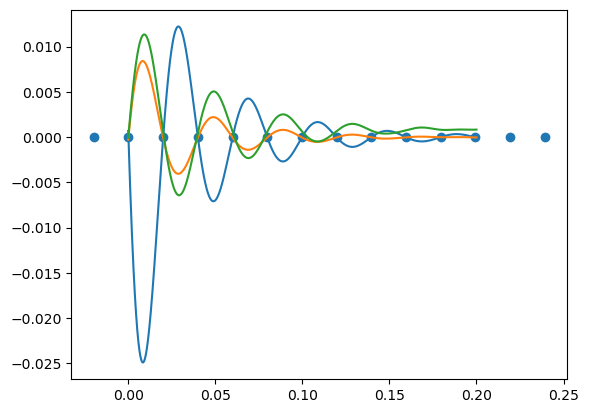

In [60]:
z = model.z
theta = model.theta
lower_t = 0.
end_t = 0.2
t_fine = jnp.linspace(lower_t,end_t,2000)
X_fine = model.predict_state(t_fine,z)
Xdot_fine = model.traj_model.derivative(t_fine,z)
colloc_res_fine = model.predict(X_fine,theta) - Xdot_fine
plt.plot(t_fine,colloc_res_fine[:,0])
plt.plot(t_fine,colloc_res_fine[:,1])
plt.plot(t_fine,colloc_res_fine[:,2])

colloc_plot = model.t_colloc[(model.t_colloc<=end_t+0.05)&(model.t_colloc>=lower_t - 0.05)]
plt.scatter(colloc_plot,0*colloc_plot)

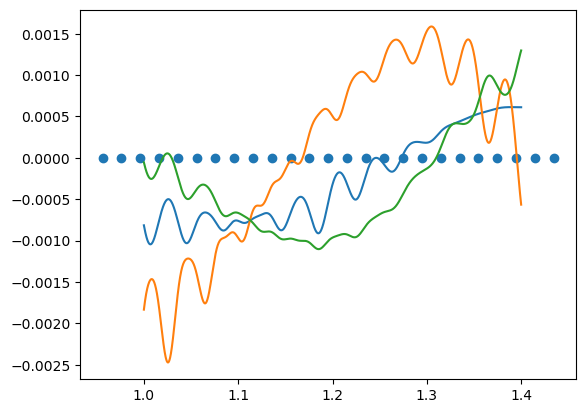

In [61]:
z = model.z
theta = model.theta
lower_t = 1.
end_t = 1.4
t_fine = jnp.linspace(lower_t,end_t,2000)
X_fine = model.predict_state(t_fine,z)
Xdot_fine = model.traj_model.derivative(t_fine,z)
colloc_res_fine = model.predict(X_fine,theta) - Xdot_fine
plt.plot(t_fine,colloc_res_fine[:,0])
plt.plot(t_fine,colloc_res_fine[:,1])
plt.plot(t_fine,colloc_res_fine[:,2])

colloc_plot = model.t_colloc[(model.t_colloc<=end_t+0.05)&(model.t_colloc>=lower_t - 0.05)]
plt.scatter(colloc_plot,0*colloc_plot)

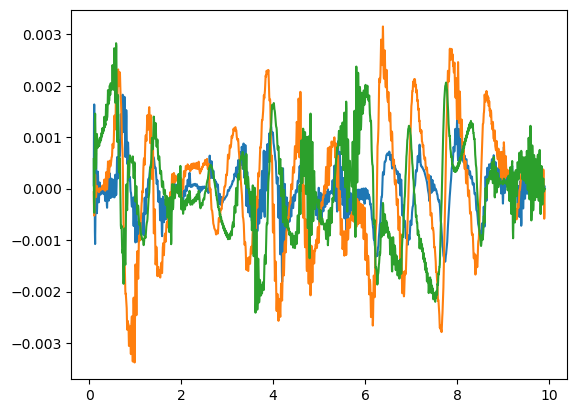

In [62]:
z = model.z
theta = model.theta
t_fine = jnp.linspace(0.1,9.9,2000)
X_fine = model.predict_state(t_fine,z)
Xdot_fine = model.traj_model.derivative(t_fine,z)
colloc_res_fine = model.predict(X_fine,theta) - Xdot_fine
plt.plot(t_fine,colloc_res_fine[:,0])
plt.plot(t_fine,colloc_res_fine[:,1])
plt.plot(t_fine,colloc_res_fine[:,2])

In [75]:
t_grid = jnp.linspace(0,10,500)

xdot_pred = model.traj_model.derivative(t_grid,model.z)
x_pred = model.predict_state(t_grid)
A = dynamics_model.feature_map(x_pred)

from pysindy import STLSQ,SR3,EnsembleOptimizer,SSR,MIOSR
stlsq = STLSQ(threshold = 0.25,alpha =0.1,unbias = True)
optimizer = stlsq

optimizer = MIOSR(7,alpha = 0.)
# EnsembleOptimizer(
#     stlsq,library_ensemble=True,
#     bagging = True,
#     n_models = 5000,
#     n_candidates_to_drop=2
#     )
# optimizer = SSR(criteria = 'model_residual',kappa = 0.1,alpha = 0.01)
optimizer.fit(A,xdot_pred)
refit_theta = jnp.array(optimizer.coef_).T

model.print(refit_theta)

(x)' = -3.061 1 + -12.454 x + 12.540 y
(y)' = 24.841 x + -0.907 x z
(z)' = -2.725 z + 1.010 x y


In [76]:
import diffrax
def model_ode(t,x,args=None):
    return model.predict(x,model.theta)

term = diffrax.ODETerm(model_ode)
solver = diffrax.Tsit5()
save_at = diffrax.SaveAt(ts = t_grid)
pidcontroller = diffrax.PIDController(rtol = 1e-8,atol = 1e-8)
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=0.001, 
    y0=initial_state,
    saveat=save_at,
    max_steps = int(100*(t1-t0)/dt),
    args = None,
    stepsize_controller=pidcontroller
)

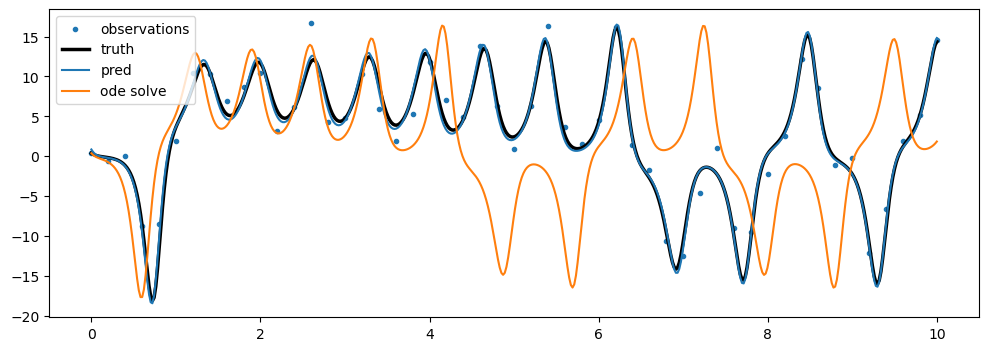

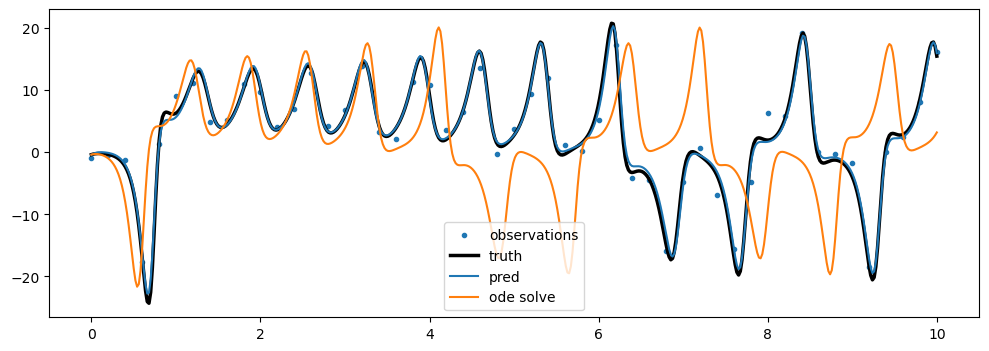

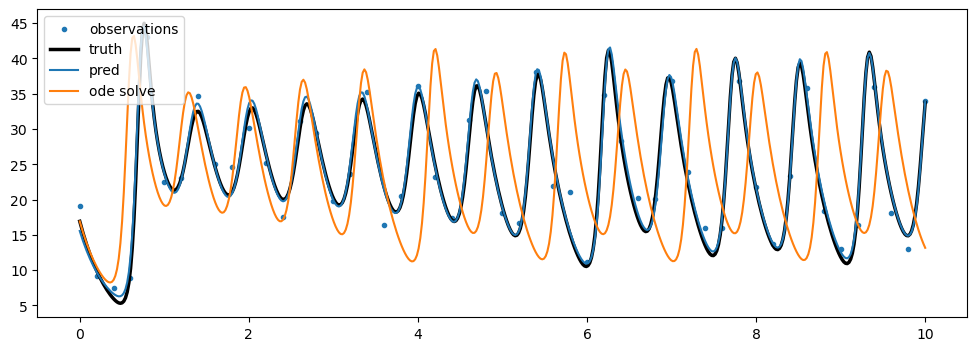

In [77]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth',c='black',lw = 2.5)
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.plot(t_grid,sol.ys[:,dim],label = 'ode solve')
    plt.legend()
    plt.show()
